# Emotion Recognition CNN
Download, Analysis, Preprocessing, Model Creation, and Training.

In [2]:
# Imports
import kagglehub
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

from train_loop import train_for_epochs

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Download Data

In [3]:
cache_path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")
print(f"Original Cache Path: {cache_path}")


data_dir = "data"

if not os.path.exists(data_dir) or not os.listdir(data_dir):
    shutil.copytree(cache_path, data_dir, dirs_exist_ok=True)
    print(f"Data copied to {data_dir}")
else:
    print(f"Data directory {data_dir} already exists and is not empty.")

data_dir = os.path.join(data_dir, "Data")

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Original Cache Path: /kaggle/input/human-face-emotions
Data copied to data


## 2. Data Analysis

Classes found: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
Class 'Angry': 10148 samples
Class 'Fear': 9732 samples
Class 'Happy': 18439 samples
Class 'Sad': 12553 samples
Class 'Suprise': 8227 samples


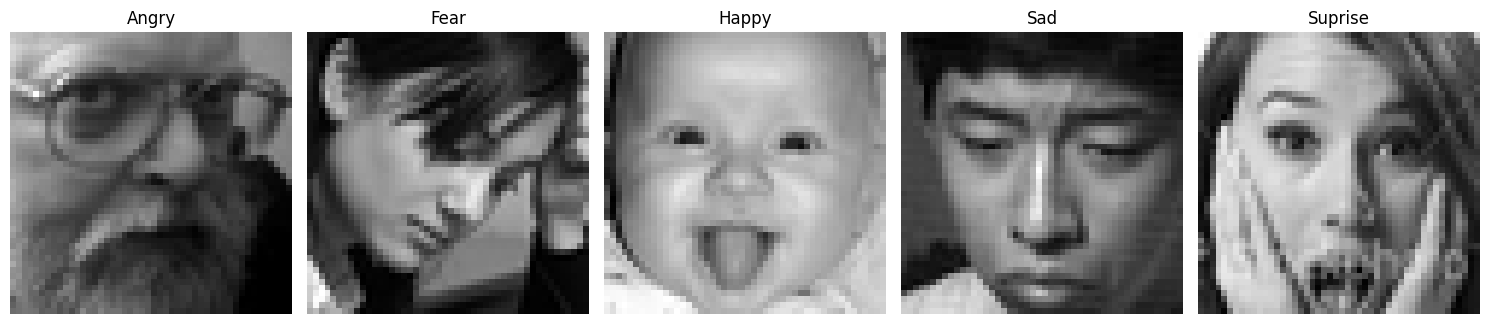

In [4]:
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
classes.sort()
print(f"Classes found: {classes}")

plt.figure(figsize=(15, 5))

for i, emotion_class in enumerate(classes):
    cls_folder = os.path.join(data_dir, emotion_class)
    images = [f for f in glob.glob(os.path.join(cls_folder, "*")) if os.path.isfile(f)]

    print(f"Class '{emotion_class}': {len(images)} samples")

    if len(images) > 0:
        img = Image.open(images[0])
        ax = plt.subplot(1, len(classes), i + 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(emotion_class)
        ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Preprocessing & Dataloaders

In [5]:
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        image = Image.open(img_path).convert("L")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Split data: train:0.8 test:0.1 val:0.1
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

all_image_paths = []
all_labels = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    class_idx = class_to_idx[class_name]
    files = glob.glob(os.path.join(class_dir, "*.*"))

    valid_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for f in valid_files:
        all_image_paths.append(f)
        all_labels.append(class_idx)

X_train, X_rest, y_train, y_rest = train_test_split(
        all_image_paths, all_labels, test_size=0.20, random_state=42, stratify=all_labels)

X_val, X_test, y_val, y_test = train_test_split(
        X_rest, y_rest, test_size=0.50, random_state=42, stratify=y_rest)

print(f"Dataset Split: Train({len(X_train)}) | Val({len(X_val)}) | Test({len(X_test)})")


Dataset Split: Train(47279) | Val(5910) | Test(5910)


In [7]:
#resizes images to 64x64 and normalizes.
IMG_SIZE = 64
BATCH_SIZE = 64

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = EmotionDataset(X_train, y_train, transform=train_transform)
val_dataset = EmotionDataset(X_val, y_val, transform=val_transform)
test_dataset = EmotionDataset(X_test, y_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 739
Val batches: 93
Test batches: 93


## 4. Custom CNN Model
4-Layer CNN with MaxPool and Dropout.

In [8]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(EmotionCNN, self).__init__()

        # Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
class DeepEmotionCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(DeepEmotionCNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16 -> 8
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [10]:
#model = EmotionCNN(num_classes=len(classes), dropout_rate=0.5690799214669463).to(device)
model = DeepEmotionCNN(num_classes=len(classes), dropout_rate=0.20433036880014452).to(device)
print(model)

DeepEmotionCNN(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


## 5. Training

In [11]:
EPOCHS = 40
#optimizer = optim.Adam(model.parameters(), lr=0.0011680662319989209, weight_decay=1.0103576576704734e-05)
optimizer = optim.RMSprop(model.parameters(), lr=0.0006419477767410103, weight_decay=1.4547307271298078e-05)

class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = total_samples / (len(classes) * class_counts)
weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=weights_tensor)

history = train_for_epochs(
    device,
    EPOCHS,
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    binary=False
)

Class weights: [1.16479428 1.21446185 0.64102773 0.94162517 1.43661501]


  0%|          | 0/40 [00:00<?, ?it/s]

## 6. Visualization

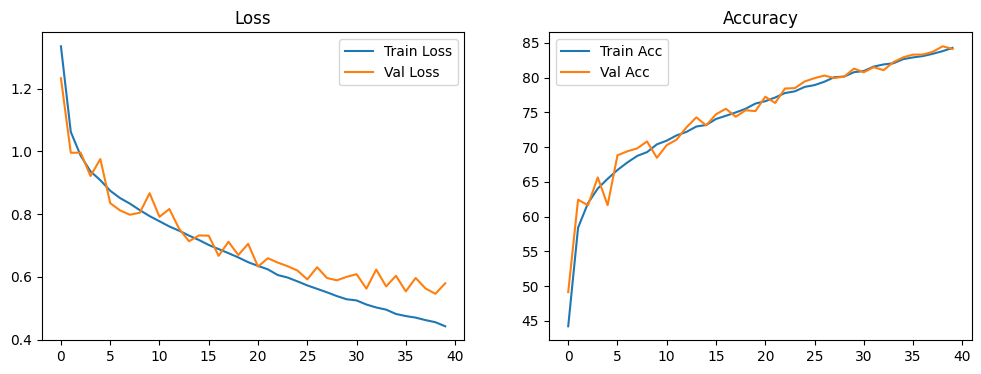

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train']['loss'], label='Train Loss')
plt.plot(history['val']['loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train']['accuracy'], label='Train Acc')
plt.plot(history['val']['accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
save_path = "emotion_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model saved to emotion_model.pth
